In [1]:
from pytrends.request import TrendReq
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Vizu settings
%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 6)

# Local imports
from utils import load_countries, plot_history, histories_to_pandas
from search_engine import SearchEngine

# reproducibility
import random
random.seed(1337)

In [2]:
COUNTRY_DIR = "docs/countries.txt"
COUNTRY_IGNORE_DIR = "docs/ignore.txt"
LANGUAGE = 'en-US'
TIME_ZONE = 360

search_engine = SearchEngine(
    pytrends = TrendReq(hl=LANGUAGE, tz=TIME_ZONE),
    supported_countries = load_countries(filename=COUNTRY_DIR, ignore=COUNTRY_IGNORE_DIR),
    fetch_interval = 1
)

### Example query: 1

```python
YEAR = 2019
SEARCH_TERMS = ["ski"]
SEARCH_COUNTRIES = ["Norway", "Sweden", "Denmark"]
```

### Example query: 2

```python
YEAR = 2019
SEARCH_TERMS = ["ski"]
SEARCH_COUNTRIES = 3 
# 0: int .. returns all available countries
# 3: int .. returns 3 random countries 
# X: int .. returns X random countries 
```

### Example query: 3

```python
YEAR = 2019
SEARCH_TERMS = ["cheese", "wine"]
SEARCH_COUNTRIES = ["Italy", "France", "Spain"]
```

In [3]:
YEAR = 2018
SEARCH_TERMS = ["Donald Trump"]
SEARCH_COUNTRIES = ["United States"]

### Query the Google API via our Search Engine

In [4]:
history_trends = search_engine.get_daily_trends_by_year(
    search_terms=SEARCH_TERMS,
    year=YEAR,
    countries=SEARCH_COUNTRIES
)

Fetching trends: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


#### Display trends

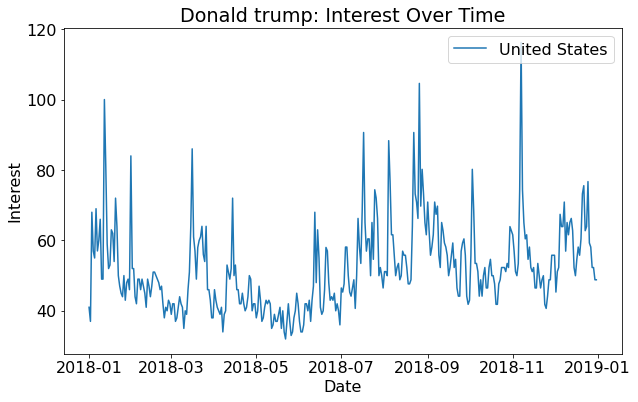

In [5]:
plot_history(history_trends, SEARCH_TERMS)

## Merge Trends to DataFrame

In [6]:
trends_df = histories_to_pandas(history_trends)

In [7]:
trends_df.head()

,date,Donald Trump,country
0,2018-01-01,41.0,United States
1,2018-01-02,37.0,United States
2,2018-01-03,68.0,United States
3,2018-01-04,57.0,United States
4,2018-01-05,55.0,United States


In [8]:
trends_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          365 non-null    datetime64[ns]
 1   Donald Trump  365 non-null    float64       
 2   country       365 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.7+ KB


### TODO

- Check if all data is valid, and doesn't contain NaN values (?)
- Save DataFrame to DataBase (?)
  - what column_names to follow?
  - allow blank spaces?
  - etc etc..

### Optionally: save to CSV

In [9]:
# trends_df.to_csv(f"trends-{YEAR}.csv", index=False)